In [1]:
#!pip install mysqlclient
#!pip install bellmanford
#!pip install networkx

In [2]:
from tqdm import tqdm
import MySQLdb as MySQLdb
import ast
import numpy as np
from ArbitrageGraph import ArbitrageGraph
#from ExchangeFeeStore import ExchangeFeeStore
import pandas as pd

In [3]:
arbitrageGraph = ArbitrageGraph(edgeTTL=5)
#exchangeFeeStore = ExchangeFeeStore()

In [4]:
sql="SELECT exchange, pair, bids, asks, id, orderbook_time FROM orderbook WHERE exchange IN ('coinfloor','kraken','bitfinex','bittrex','gdax','bitstamp','coinbase','poloniex') ORDER BY ID LIMIT 1000;"

In [5]:
db = MySQLdb.connect(
    host="orderbook.cyifbgm0zwt0.eu-west-2.rds.amazonaws.com",
    user="admin",
    passwd="123Qwe123Qwe",
    db="orderbook",
    port=3306)
cursor = db.cursor()
nof_rows=cursor.execute(sql)

In [6]:
df = pd.DataFrame(columns=['id','length','profit_perc','nodes','edges'])

In [7]:
#for row in tqdm(cursor.fetchall()):
for row in tqdm(cursor):
    exchangename = row[0]
    symbol = row[1]
    bids_str = row[2]
    asks_str = row[3]
    id_str = int(row[4])
    timestamp = float(row[5])
    #import ipdb; ipdb.set_trace()
    try:
        l_ask = float(ast.literal_eval(asks_str)[0][0])
        h_bid = float(ast.literal_eval(bids_str)[0][0])
        #print("%s,%s,%f,%f,%d,%f" % (exchangename, symbol, h_bid, l_ask,id_str,timestamp))
        length, nodes, negative_cycle = arbitrageGraph.update_point(
            symbol,
            exchangename,
            0.0026, #exchangeFeeStore.getTakerFee(exchangename,symbol),
            l_ask,
            h_bid,
            timestamp)
        
        if negative_cycle == True:
            edges=arbitrageGraph.nodeslist_to_edges(nodes)
            df=df.append(pd.DataFrame([[int(id_str),length,np.exp(-length)*100-100,",".join(str(x) for x in nodes),",".join(str(x) for x in edges)]], columns=['id','length','profit_perc','nodes','edges']),ignore_index=True)
            #print("length:",length,"ratio",np.exp(-length),'nodes',nodes,'edges',edges)
            #arbitrageGraph.plot_graph()
    except IndexError:
        print("*** Invalid orderbook ***")


1000it [00:02, 485.93it/s]


In [8]:
db.close()

In [9]:
df.head()

,id,length,profit_perc,nodes,edges
0,6614,-0.000586,0.058611,"kraken-USD,bitstamp-USD,bitstamp-ETH,kraken-ET...","0.0,6.042858097147529,0.0,-6.0434440390081585"
1,6624,-0.000586,0.058611,"kraken-USD,bitstamp-USD,bitstamp-ETH,kraken-ET...","0.0,6.042858097147529,0.0,-6.0434440390081585"
2,6631,-0.000586,0.058611,"kraken-USD,bitstamp-USD,bitstamp-ETH,kraken-ET...","0.0,6.042858097147529,0.0,-6.0434440390081585"
3,6632,-0.000586,0.058611,"kraken-USD,bitstamp-USD,bitstamp-ETH,kraken-ET...","0.0,6.042858097147529,0.0,-6.0434440390081585"
4,6635,-0.000586,0.058611,"kraken-USD,bitstamp-USD,bitstamp-ETH,kraken-ET...","0.0,6.042858097147529,0.0,-6.0434440390081585"


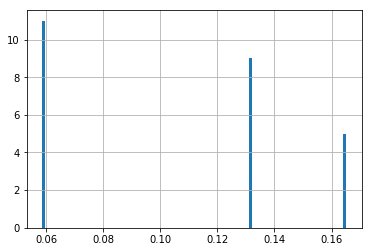

In [10]:
df['profit_perc'].hist(bins=100)

In [11]:
df.to_csv("arbitrage.csv",index=False)